<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Eletronics Purchase Prediction</h1>

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file rerepresents an event. All events are related to products and users. Each event is like many-many relation between users and products. 

## Learning Objectives

At the end of this session, you will be able to
- Detect data imbalance
- Practice more on preprocessing features
- Build logistic regression / SVM / Gradient Boosting / Random Forest models
- Evaluate models with proper metrics
- Interpret black box models

## Task 1: Load data

We start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

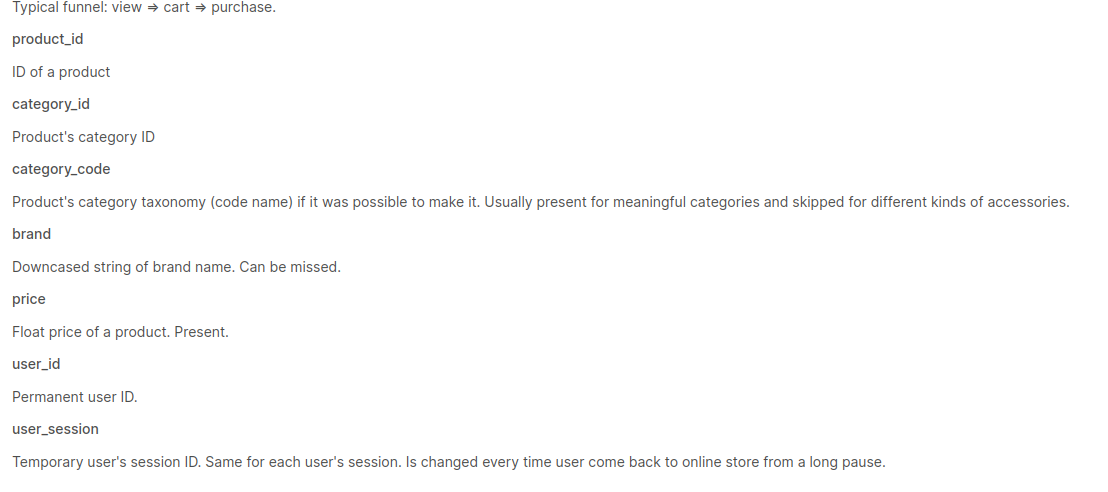

In [1]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

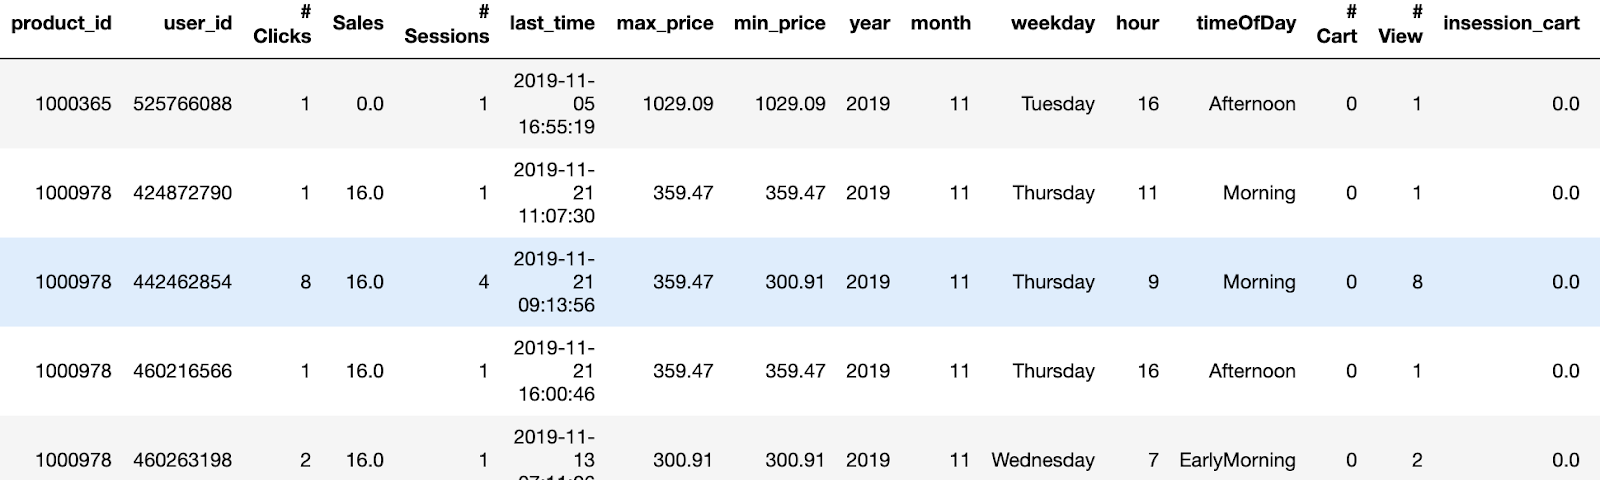

In [76]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has either 0 (not purchased) or 1 (purchased).

In [77]:
import pandas as pd
train_df = pd.read_csv("../dat/train.csv.gz")

In [78]:
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


4. What is the dimension of the training data?

In [79]:
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [80]:
test_df = pd.read_csv("../dat/test.csv.gz")
test_df.shape

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. As part of this, we will want to identify what features are most important for making this classification.

We'll start with digging into our dataset.

1. For the training data, print out the datatype of each feature (column), and identify which ones are non-numeric.

In [81]:
train_df.select_dtypes(exclude=['int', 'float']).columns

Index(['weekday', 'timeOfDay'], dtype='object')

<details> 
<summary>Expected output:</summary>

    NumOfEventsInJourney      int64
    NumSessions               int64
    interactionTime         float64
    maxPrice                float64
    minPrice                float64
    NumCart                   int64
    NumView                   int64
    InsessionCart             int64
    InsessionView             int64
    year                      int64
    month                     int64
    weekday                  object
    timeOfDay                object
    Weekend                   int64
    Purchase                  int64
    dtype: object
</details>

2. Print the unique values for the year, month and weekend features.

In [82]:
print('   year:', train_df.year.unique())
print('  month:', train_df.month.unique())
print('weekend:', train_df.Weekend.unique())

   year: [2019]
  month: [11]
weekend: [0]


In [83]:
print('weekend:', train_df.Weekend.count())
#Weekend

weekend: 645816


What does weekend: 0 mean?

#### weekend:0 is a categorical column that indicates if the day in which the purchase happened ( or did not happen ) was a weekend or not.

3. Since these columns each only have one unique value, they will not be valuable features, we drop the three columns in the training set. Pass the `columns` argument to the `.drop()` method. Make sure to use `inplace=True` to modify the DataFrame. Print the shape of the DataFrames to verify the columns were dropped.

#### Intial Train dataset dimensions:

In [84]:
train_df.shape

(645816, 15)

In [85]:
columns_to_drop = ['year','month','Weekend']
train_df = train_df.drop(columns_to_drop, axis=1, inplace=False)

#### After dropping above columns in Train dataset dimensions:

In [86]:
train_df.shape

(645816, 12)

<details> 
<summary>Expected output:</summary>

   (645816, 15)
   
   (645816, 12)
</details>

4. Repeat the step for `test_df`:

#### Intial Test dataset dimensions:

In [87]:
test_df.shape

(430544, 15)

In [88]:
columns_to_drop = ['year','month','Weekend']
test_df = test_df.drop(columns_to_drop, axis=1, inplace=False)

#### After dropping above columns in Test dataset dimensions:

In [89]:
test_df.shape

(430544, 12)

<details> 
<summary>Expected output:</summary>

(430544, 15)

(430544, 12)
</details>

4. For each non-numeric feature, print the unique values.

In [90]:
print('  weekday:', train_df.weekday.unique())
print('timeOfDay:', train_df.timeOfDay.unique())

  weekday: ['Sat' 'Fr' 'Thu' 'Mon' 'Tue' 'Wed' 'Sun']
timeOfDay: ['Morning' 'Dawn' 'Afternoon' 'Noon' 'Evening' 'EarlyMorning' 'Night']


<details>
<summary> Expected output:</summary>
  
  weekday: ['Wed' 'Fr' 'Sat' 'Sun' 'Tue' 'Thu' 'Mon']

timeOfDay: ['EarlyMorning' 'Morning' 'Afternoon' 'Dawn' 'Evening' 'Night' 'Noon']
</details>

5. Convert the non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to do so. Follow the example given for the `weekday` column to update the `timeOfDay` column. Use the `.head()` method to inspect the dataset after the transformations.

#### For converting nominal categorical columns ( weekday ,timeOfDay ) , I'd use TARGET ENCODING. As we can clearly see, there is no relationship between the values of the categorical columns ( weekday ,timeOfDay ). For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories). When we're doing supervised learning, we often have to deal with categorical variables. That is, variables which don’t have a natural numerical representation. The problem is that most machine learning algorithms require the input data to be numerical. At some point or another a data science pipeline will require converting categorical variables to numerical variables.

#### There are many ways to do so:

### 1. Label encoding:
##### Where you choose an arbitrary number for each category

### 2. One-hot encoding:
##### where you create one binary column per category
### 3. Vector representation: 
#####  a.k.a. word2vec where you find a low dimensional subspace that fits your data
### 4. Optimal binning:
#####  where you rely on tree-learners such as LightGBM or CatBoost
### 5. Target encoding:
#####  where you average the target value by category

#### Each and every one of these method has its own pros and cons. Target encoding is a fast way to get the most out of your categorical variables with little effort. The idea is quite simple. Say you have a categorical variable  and a target  –  can be binary or continuous, it doesn’t matter. For each distinct element in  you’re going to compute the average of the corresponding values in.

### Applying Target Encoding on the ordinal categorical columns of the Training Dataset:

In [91]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

train_df['weekday'] = calc_smooth_mean(train_df, by='weekday', on='Purchase', m=10)
train_df['timeOfDay'] = calc_smooth_mean(train_df, by='timeOfDay', on='Purchase', m=10)

In [92]:
train_df.shape

(645816, 12)

In [93]:
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,0.012514,0.019041,0
1,1,1,0.0,92.67,92.67,0,1,0,1,0.008547,0.011343,0
2,1,1,0.0,155.71,155.71,0,1,0,1,0.011979,0.012898,0
3,1,1,0.0,898.32,898.32,0,1,0,1,0.015025,0.017025,0
4,1,1,0.0,146.21,146.21,0,1,0,1,0.013736,0.017025,0


Expected output:

Do the same for test_df, that is, to convert weekday and timeOfDay into numeric.

#### Applying Target Encoding on the ordinal categorical columns of the Test Dataset:

In [94]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

test_df['weekday'] = calc_smooth_mean(test_df, by='weekday', on='Purchase', m=10)
test_df['timeOfDay'] = calc_smooth_mean(test_df, by='timeOfDay', on='Purchase', m=10)

In [95]:
test_df.shape

(430544, 12)

#### Below code just randomly assigns numerical codes to categories which is not how we should treat categorical variables:

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Are the datasets balanced?

In [96]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
print(f"percent of rows resulting in purchase: {(train_df.Purchase.value_counts()[1]/train_df.Purchase.value_counts()[0]):.2f}%") # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase: 0.01%


<details>

<summary> Expected output:</summary>

    number of purchases vs non-purchases in train set:
    0    636839
    1      8977
    Name: Purchase, dtype: int64
    percent of rows resulting in purchase: 1.39%
<details>

## Task 3: Remove highly correlated features

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [97]:
train_df.shape

(645816, 12)

#### Currently, we have 12 features.

<details>
<summary>Expected output:</summary>
    
    The training data currently has 11 features
</details>

2. Draw a heatmap of the Pearson correlation.

    The plotting code is given to you, but you need to fill in the calculation of the Pearson correlation (`pd.DataFrame.corr()`). Note that we here use a smaller sample of the total training dataset for calculating correlation and rendering heatmap. 

In [98]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 

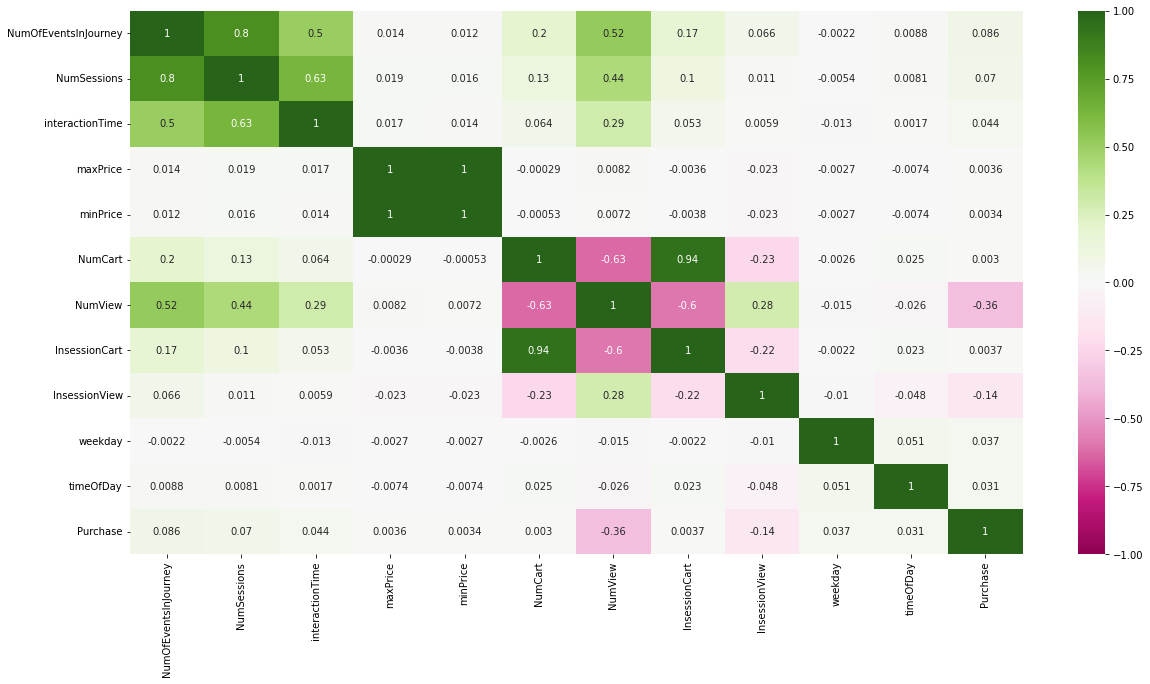

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
cor = pd.DataFrame.corr(train_df)
sns.heatmap(cor, vmin=-1, vmax=1, cmap="PiYG", annot=True);

In [100]:
# Expected output:

3. Drop the features with high correlation.

    We'll do this by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given the code, make sure that you understand what each line does.

In [101]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [102]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


4. How many columns are left in the DataFrame?

In [103]:
train_df_reduced.shape

(645816, 9)

In [104]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

5. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [105]:
test_df_reduced = test_df[selected_columns]
test_df.columns

Index(['NumOfEventsInJourney', 'NumSessions', 'interactionTime', 'maxPrice',
       'minPrice', 'NumCart', 'NumView', 'InsessionCart', 'InsessionView',
       'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

In [106]:
test_df_reduced.shape

(430544, 9)

6. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

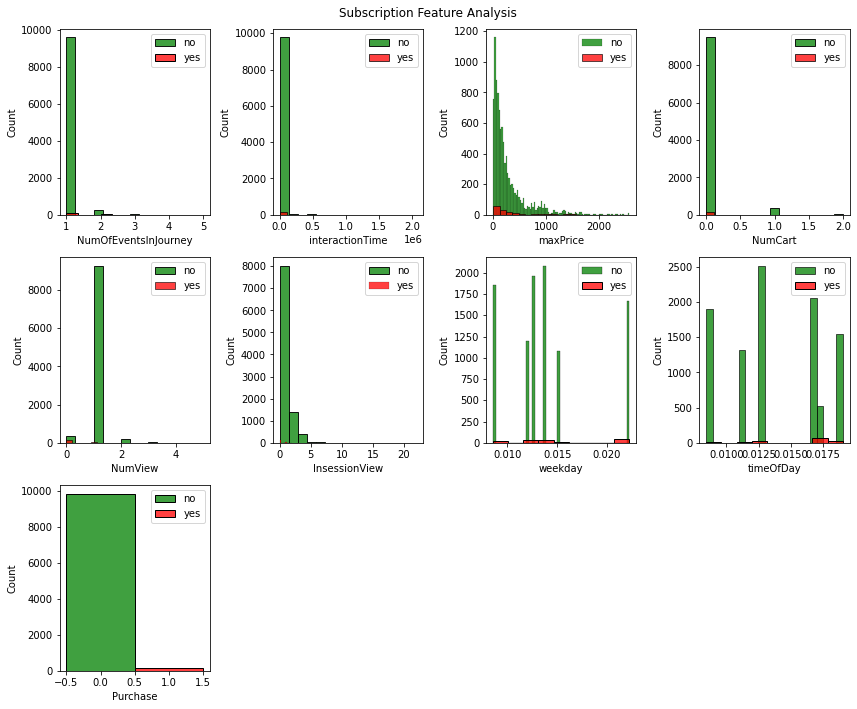

In [107]:
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

#### Let’s create a pairplot using scatterplot for each column individually.

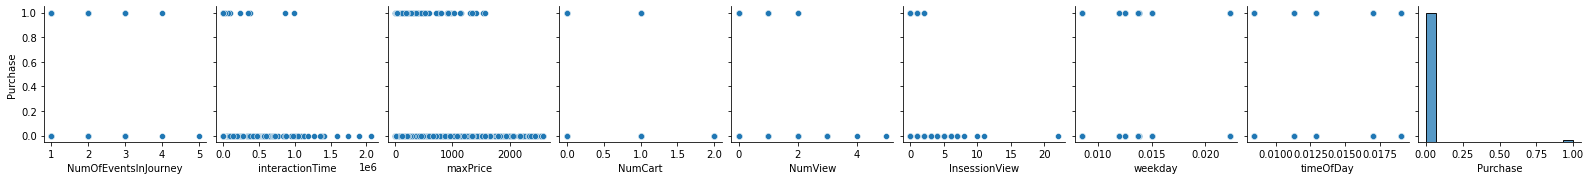

In [108]:
sns.pairplot(train_small_df_reduced, y_vars="Purchase", x_vars=train_small_df_reduced.columns.values)

#### Key Insights from the above Scatter Graph :
    1. As the maxPrice goes higher (than 1500), it often does not lead to a Purchase.
    2. As the InteractionTime goes higher (than 1), it often does not lead to a Purchase.
    3. Puchases are not dependent on which day of the week or time it is.

In [109]:
train_small_df_reduced.shape

(10000, 9)

7. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [114]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values

8. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_reduced = scaler.fit(X_train_reduced)
X_test_reduced = scaler.fit(X_test_reduced)

## Task 4: Build logistic regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict with the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter.

    Remember to use the ***train*** data for building the model and the ***test*** data when making and evaluating the predictions

### finding optimal weights for Logistic Regression using grid search:
Finally, we are trying to find optimal weights with the highest score using grid search. We will search for weights between 0 to 1. The idea is, if we are giving n as the weight for the minority class, the majority class will get 1-n as the weights.

Here, the magnitude of the weights is not very large but the ratio of weights between majority and minority class will be very high.

Example:

w1 = 0.95

w0 = 1 – 0.95 = 0.05

w1:w0 = 19:1

So, the weights for the minority class will be 19 times higher than the majority class.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'Scoring for different class weights')

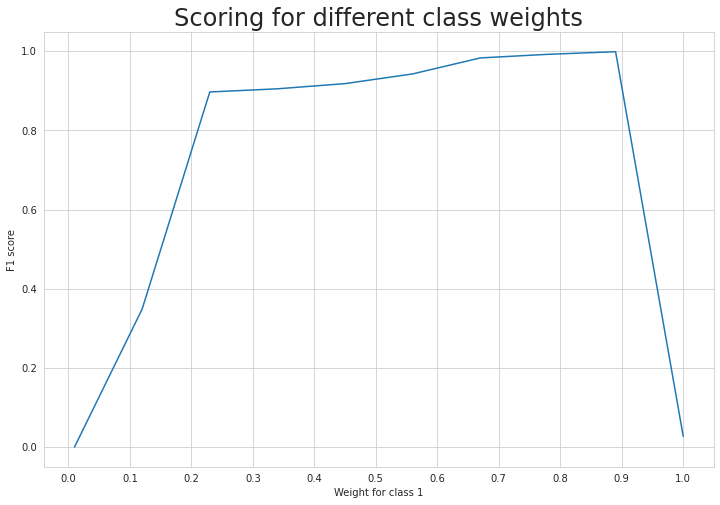

In [115]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_dist = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = RandomizedSearchCV(estimator= lr, 
                          param_distributions=param_dist,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_reduced, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

###### Through the graph we can see that the highest value for the minority class is peaking at about 0.89 class weight.
Using randomized cv search, we got the best class weight, i.e.  0.11 for class 0 (majority class), 1: 0.89 for class 1 (minority class). Now that we have our best class weights using stratified cross-validation and grid search, we will see the performance on the test data.

In [116]:
%%time
#Training the model using mode of target
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

lr_model = LogisticRegression(solver='newton-cg', class_weight={0: 0.11, 1: 0.89})
lr_model.fit(X_train_reduced, y_train)
# Predicting on the test data
lr_pred = lr_model.predict(X_test_reduced)

The line search algorithm did not converge
The line search algorithm did not converge


CPU times: user 1min 53s, sys: 2min 37s, total: 4min 31s
Wall time: 40 s


newton-cg failed to converge. Increase the number of iterations.


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [437]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9999024489947601
precision: 0.9995069033530573
recall: 0.9936274509803922
f1 score: 0.996558505408063
confusion matrix:
[[424421      3]
 [    39   6081]]


4. Instantiate, train and predict with the SVM mode. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account fo the imbalanced classes.

In [ ]:
%%time
from sklearn import svm

clf2= svm.SVC(class_weight='balanced')# define model
clf2.fit(X_train_reduced, y_train)
svm_pred = clf2.predict(X_test_reduced)

5. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

    The loss function of Logistic regression is a lot smoother where SVMs are only convex, so that helps LR be "faster" from an optimization perspective. If n is large (1–10,000) and m is small (10–1000) : use logistic regression

6. Calculate the classification metrics for the SVM model. Here you can use a helper function to display all the metrics, inspect the source code to understand how to use the function.

In [ ]:
from utils import display_metrics
display_metrics(y_test, svm_pred)

<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424424      0]
    [     0   6120]]
    Accuracy: 1.000
    Recall: 1.000
    Precision: 1.000
    F1 Score: 1.000

</details>

Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

##### Where SVM becomes extremely powerful is when it is combined with kernels. We have seen a version of kernels before, in the basis function regressions of In Depth: Linear Regression. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier. In SVM models, we can use a version of the same idea. 

## Task 5: Fit a non-linear classifier: gradient boosted tree

1. Instantiate, train, and predict with the Gradient Boosted Trees model.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
%%time
gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 21.6 s, sys: 62.5 ms, total: 21.7 s
Wall time: 21.9 s


2. Evaluate the model by calculating the classification metrics.

In [42]:
from utils import display_metrics
display_metrics(y_test, gbt_pred)

Confusion Matrix: 
[[423469    955]
 [   194   5926]]
Accuracy: 0.997
Recall: 0.968
Precision: 0.861
F1 Score: 0.912


<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424423      1]
    [    16   6104]]
    Accuracy: 1.000
    Recall: 0.997
    Precision: 1.000
    F1 Score: 0.999

</details>

## Task 6: Analyze importace of data sample balancing with random forest model

1. Instantiate, train, predict with, and evaluate an unbalanced random forest classifier. (Follow the same steps you did above with the other models). You can use 100 trees in the forest, and set the maximum depth of the tree at 5. 

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
%%time
rf_model = RandomForestClassifier(max_depth=2, random_state=0)
rf_model.fit(X_train_reduced, y_train)
rf_pred = rf_model.predict(X_test_reduced)

CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 19 s


In [45]:
display_metrics(y_test, rf_pred)

Confusion Matrix: 
[[424424      0]
 [  6120      0]]
Accuracy: 0.986
Recall: 0.000
Precision: 0.000
F1 Score: 0.000


/home/krishanu_sinha/anaconda3/envs/mle-course/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2. Repeat the previous exercise, but this time, incorporate **class-balanced penalty weights**

In [46]:
%%time
rf_model_b = RandomForestClassifier( max_depth=2, random_state=0, class_weight='balanced_subsample')
rf_model_b.fit(X_train_reduced, y_train)
rf_pred_b = rf_model_b.predict(X_test_reduced)

CPU times: user 33 s, sys: 15.6 ms, total: 33 s
Wall time: 33 s


In [47]:
display_metrics(y_test, rf_pred_b)

Confusion Matrix: 
[[397691  26733]
 [     0   6120]]
Accuracy: 0.938
Recall: 1.000
Precision: 0.186
F1 Score: 0.314


3. Visualize a Decision Tree. Spend some time inspecting this visualization of the tree--what does each line in the boxes mean? Discuss this with your partners. What does the "value=..." line indicate?

In [51]:
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(rf_model_b.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = selected_columns[:-1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
# MacOS: brew install graphviz
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

#Image(filename = 'tree.png')

4. Look at the results below to note the most important features.

In the cell below we show you how to use a Random Forest to rank features based on a measure of importance called the Gini Importance. We'll provide you with all the code, but you may want to read up on sklearn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and its [feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) property.

Feature ranking:
1. NumView (feature 4) (0.343631)
2. InsessionView (feature 5) (0.308414)
3. NumOfEventsInJourney (feature 0) (0.115333)
4. interactionTime (feature 1) (0.110787)
5. weekday (feature 6) (0.050273)
6. NumCart (feature 3) (0.037742)
7. timeOfDay (feature 7) (0.027901)
8. maxPrice (feature 2) (0.005919)


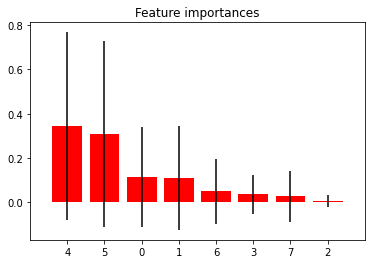

In [52]:
# Use Random Forest to get feature ranks/importances for each feature
importances = rf_model_b.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_b.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_reduced.shape[1]):
    print("%d. %s (feature %d) (%f)" %
          (f + 1, train_df_reduced.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_reduced.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_reduced.shape[1]), indices)
plt.xlim([-1, X_train_reduced.shape[1]]);

Thus features 4 and 5 (numview, InsessionView) are the top two most important features (according to the Random Forest model). Is this what you expected? Bonus question, is it necessary to scale features for when fitting random forest models?

## Advanced Visualizations with Streamlit and Plotly!
Let's write visualize our results in a way that makes it easy to compare our models!  [Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [59]:
from sklearn.metrics import confusion_matrix

# Create our confusion matricies
confusion_lr = confusion_matrix(y_test, lr_pred)
#confusion_svm = confusion_matrix(y_test, svm_pred)
confusion_gb = confusion_matrix(y_test, gbt_pred)
confusion_rf = confusion_matrix(y_test, rf_pred_b)

# Let's collect all of our metrics!
tn = [confusion_lr[0][0], confusion_gb[0][0], confusion_rf[0][0]]
fp = [confusion_lr[0][1], confusion_gb[0][1], confusion_rf[0][1]]
fn = [confusion_lr[1][0], confusion_gb[1][0], confusion_rf[1][0]]
tp = [confusion_lr[1][1], confusion_gb[1][1], confusion_rf[1][1]]

accuracy_scores = [accuracy(y_test, lr_pred), accuracy(y_test, gbt_pred), accuracy(y_test, rf_pred_b)]
recall_scores = [recall(y_test, lr_pred), recall(y_test, gbt_pred), recall(y_test, rf_pred_b)]
f1_scores = [f1_score(y_test, lr_pred), f1_score(y_test, gbt_pred), f1_score(y_test, rf_pred_b)]

models = ["Logistic Regression", "Gradient Boosting Classifier", "Random Forest"]
results_data = {"model":models, "tn": tn, "fp": fp, "fn": fn, "tp": tp, "accuracy": accuracy_scores, "recall": recall_scores, "f1_score": f1_scores}

results_df = pd.DataFrame(results_data)
print(results_df)

                          model      tn     fp   fn    tp  accuracy    recall  \
0           Logistic Regression  424421      3   39  6081  0.999902  0.993627   
1  Gradient Boosting Classifier  423469    955  194  5926  0.997331  0.968301   
2                 Random Forest  397691  26733    0  6120  0.937909  1.000000   

   f1_score  
0  0.996559  
1  0.911622  
2  0.314064  


In [60]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

Now go to your terminal, navigate to the folder containing this assignment and run `streamlit run electronics-purchase-predictions-streamlit.py`.  This will open your browser with the streamlit app.

## Optional Task: Explanability with SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

For this optional task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. Can you apply `shap.Explainer()` to calculate the SHAP values for the XGBoost and Random Forest models you fit earlier, visualize the effects over all samples using `shap.plots.beeswarm()` and interpret the results? Consider experimenting it on a smaller dataset first.  

Once you're done, write your data to file and add them under the Model Explainability tab in the Streamlit app, following the example in Model Results tab.

Want to get more details? Please go ahead and check these links:

1. [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
2. [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

In [117]:
import shap
pd.set_option("display.max_columns",None)
shap.initjs()
import xgboost

In [121]:
explainer = shap.LinearExplainer(lr_model, X_train_reduced)
shap_values = explainer.shap_values(X_test_reduced)

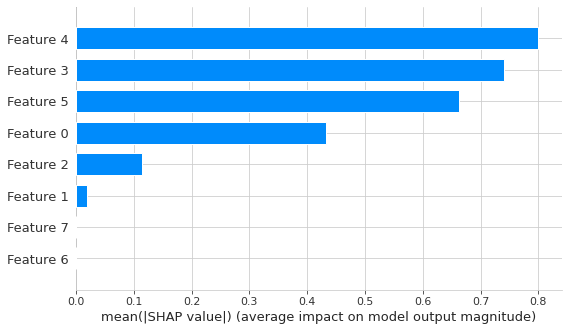

In [119]:
shap.summary_plot(shap_values, X_test_reduced, plot_type='bar')

#### Top Features as indicated by SHAP VALUES ARE:
1. NumView (feature 4) 
2. NumCart (feature 3)
3. InsessionView (feature 5) 
4. NumOfEventsInJourney (feature 0) 
5. maxPrice (feature 2) (0.005919)
6. interactionTime (feature 1) (0.110787)


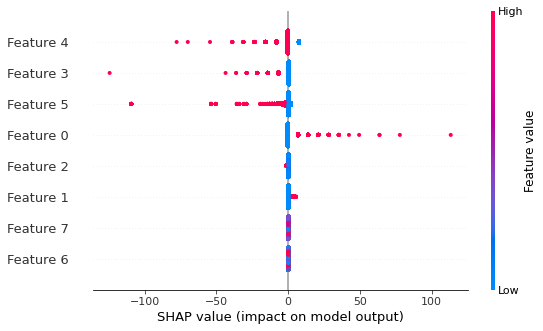

In [75]:
shap.summary_plot(shap_values,X_test_reduced)

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)